In [1]:
import numpy as np

#### Loading Data

In [2]:
import urllib.request
import os

# Check if data is already there and only download if it isnt
if not os.path.exists('optdigits.tra') and not os.path.exists('optdigits.tes'):

    # URLs for the dataset
    train_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
    test_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

    urllib.request.urlretrieve(train_url, 'optdigits.tra') # training data
    urllib.request.urlretrieve(test_url, 'optdigits.tes') # test data

In [3]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    inputs = (data[:, :-1] - 8) / 8.0 # Normalize the inputs between -1 and 1
    targets = np.eye(10)[data[:, -1].astype(int)]  # One-hot encoding
    return list(zip(inputs, targets))

# Load the training and test data
train_data = load_data('optdigits.tra')
test_data = load_data('optdigits.tes')

In [4]:
train_data[0]

(array([-1.   , -0.875, -0.25 ,  0.875,  0.5  , -0.875, -1.   , -1.   ,
        -1.   , -0.125,  1.   , -0.25 , -0.25 ,  0.25 , -1.   , -1.   ,
        -1.   ,  0.   ,  1.   , -0.75 , -1.   ,  0.375, -0.75 , -1.   ,
        -1.   , -0.375,  1.   , -0.625, -1.   , -0.375, -0.125, -1.   ,
        -1.   , -0.125,  0.625, -0.625, -1.   ,  0.   , -0.125, -1.   ,
        -1.   , -0.5  ,  0.5  , -1.   , -0.875,  0.625, -0.375, -1.   ,
        -1.   , -1.   ,  0.75 ,  0.125,  0.875,  0.125, -1.   , -1.   ,
        -1.   , -1.   , -0.25 ,  0.75 , -0.125, -0.875, -1.   , -1.   ]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

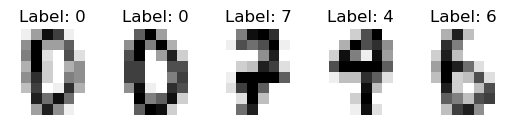

In [5]:
import matplotlib.pyplot as plt

# Function to draw images
def draw_images(data, num_images):
    for index, (image, label) in enumerate(data[:num_images]):
        plt.subplot(1, num_images, index + 1)
        plt.axis('off')
        plt.imshow(image.reshape((8,8)), cmap=plt.cm.gray_r)
        label = np.argmax(label)
        plt.title('Label: %i' % label, fontsize = 12)
    plt.show()

# Draw some images from the training data
draw_images(train_data, 5)

In [6]:
def data_generator(data, minibatch_size):
    np.random.shuffle(data)
    for i in range(0, len(data), minibatch_size):
        minibatch = data[i:i+minibatch_size]
        inputs = np.array([item[0] for item in minibatch])
        targets = np.array([item[1] for item in minibatch])
        yield inputs, targets

# Create a data generator with minibatch size of 10
train_data_gen = data_generator(train_data, 10)


#### 2.2, 2.3 Activation Functions

In [7]:
class Module:
    """Abstract module class that NN are composed off"""
    def __call__(self, input):
        # Forward pass/inference
        raise NotImplementedError
    
    def back(self, grad):
        # Backward pass/derivative
        raise NotImplementedError

    def parameters(self):
        # Return list of parameters
        return []
    
    def __str__(self):
        return self.__class__.__name__ + '()'

In [8]:
class Sigmoid(Module):
    """Sigmoid activation function"""
    def __call__(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def back(self, grad):
        return grad * self.output * (1 - self.output)
    
    def __str__(self):
        return self.__class__.__name__

In [9]:
class Softmax(Module):
    """Softmax activation function"""
    def __call__(self, input):
        exp = np.exp(input - np.max(input, axis=-1, keepdims=True))
        self.output = exp / np.sum(exp, axis=-1, keepdims=True)
        return self.output
    
    def back(self, grad):
        return grad * self.output * (1 - self.output)
    
    def __str__(self):
        return self.__class__.__name__

#### 2.4 Layer

In [10]:
class Parameter:
    """Parameter class for NN parameters"""
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)
        #self.reset()

    def reset(self):
        self.grad = np.zeros_like(self.data)

In [11]:
class Linear(Module):
    """Linear layer"""
    def __init__(self, input_size, output_size, activation=None):
        self.weights = Parameter(np.random.randn(input_size, output_size) * 0.01)
        self.bias = Parameter(np.zeros(output_size))
        self.activation = activation
    
    def __call__(self, input):
        self.input = input
        self.output = np.dot(input, self.weights.data) + self.bias.data

        self.output = self.activation(self.output) if self.activation else self.output

        return self.output
    
    def back(self, grad):
        grad = self.activation.back(grad) if self.activation else grad
        
        self.weights.grad = np.dot(self.input.T, grad)
        self.bias.grad = np.sum(grad, axis=0)
        return np.dot(grad, self.weights.data.T)
    
    def parameters(self):
        return [self.weights, self.bias]

    def __str__(self):
        return self.__class__.__name__ + '(in=' + str(self.weights.data.shape[0]) + ', out=' + str(self.weights.data.shape[1]) + str(', activation=' + str(self.activation)) + ')' if self.activation else ')'

#### 2.5 Model

In [12]:
class Model(Module):
    """Simple model"""
    def __init__(self):
        self.layers = [Linear(64, 32, activation=Sigmoid()),
                       Linear(32, 10, activation=Softmax())]
    
    def __call__(self, input):
        for layer in self.layers:
            input = layer(input)
        return input
    
    def back(self, grad):
        for layer in reversed(self.layers):
            grad = layer.back(grad)
        return grad
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
    
    def zero_grad(self):
        for param in self.parameters():
            param.reset()

    def __str__(self):
        total_params = sum(np.prod(param.data.shape) for layer in self.layers for param in layer.parameters())
        return "Model(\n  " + "\n  ".join([str(layer) for layer in self.layers]) + "\n), Param count: " + str(total_params)

#### 2.6 CCE

In [13]:
class CCE:
    """Categorical cross-entropy loss"""
    
    def __call__(self, y_pred, y_true):
        # Clip prediction to avoid log(0) error
        y_pred = np.clip(y_pred, 1e-9, 1. - 1e-9)
        self.y_pred = y_pred
        self.y_true = y_true
        return -np.sum(y_true * np.log(y_pred))
    
    def back(self):
        return self.y_pred - self.y_true

In [14]:
# test forward pass
model = Model()
cce = CCE()
x, y = next(train_data_gen)
output = model(x)
assert output.shape == (10, 10)

# test backward pass
grad = cce(output, y)
grad = model.back(grad)
assert grad.shape == (10, 64)

In [15]:
print(model)

Model(
  Linear(in=64, out=32, activation=Sigmoid)
  Linear(in=32, out=10, activation=Softmax)
), Param count: 2410


#### 3.6 Training

In [16]:
class Optimizer:
    """Abstract optimizer class"""
    def __init__(self, parameters):
        self.parameters = parameters
    
    def step(self):
        raise NotImplementedError

class SGD(Optimizer):
    """Stochastic gradient descent optimizer"""
    def __init__(self, parameters, lr=1e-2):
        super().__init__(parameters)
        self.lr = lr
    
    def step(self):
        for param in self.parameters():
            param.data -= self.lr * param.grad

In [17]:
def training_step(model, loss, optimizer, x, y):
    output = model(x)
    loss_result = loss(output, y)
    grad = loss.back()
    model.back(grad)
    optimizer.step()
    model.zero_grad()
    
    return loss_result

def training_loop(model, loss, optimizer, train_data, test_data, epochs, minibatch_size):
    epoch_accuracies = []
    epoch_losses = []
    for epoch in range(epochs):
        train_data_gen = data_generator(train_data, minibatch_size)
        test_data_gen = data_generator(test_data, minibatch_size)
        
        # Training
        losses = []
        for x, y in train_data_gen:
            loss_result = training_step(model, loss, optimizer, x, y)
            losses.append(loss_result)
        epoch_loss = np.mean(losses)

        # Testing
        total = 0
        correct = 0
        for x, y in test_data_gen:
            output = model(x)
            correct += np.sum(np.argmax(output, axis=-1) == np.argmax(y, axis=-1))
            total += len(x)
        print(f'Epoch: {epoch+1}, Accuracy: {correct/total:.3f}, Loss: {epoch_loss:.3f}')
        epoch_accuracies.append(correct/total)
        epoch_losses.append(epoch_loss)

    return epoch_accuracies, epoch_losses


In [36]:
import matplotlib.pyplot as plt

def plot_training_results(accuracies, losses, max_steps=20):
    # Create a figure and a set of subplots
    epoch_idx = range(1,len(accuracies)+1)
    x_ticks = list(range(1, len(accuracies) + 1))
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    def plot(ax, data, title, y_label, color):
        ax.plot(epoch_idx, data, label=title, color=color)
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(y_label)
        ax.set_xticks(x_ticks)
        ax.legend()
        ax.grid(True)
    
    # Plotting training loss
    plot(axs[0], losses, 'Training Loss Over Epochs', 'Loss', 'red')
    plot(axs[1], accuracies, 'Training Accuracy Over Epochs', 'Accuracy', 'blue')
    
    plt.tight_layout()
    plt.show()

In [37]:
# Train the model
model = Model()
loss = CCE()
optimizer = SGD(model.parameters, lr=1e-1)

accuracies, losses = training_loop(model, loss, optimizer, train_data, test_data, epochs=15, minibatch_size=64)

Epoch: 1, Accuracy: 0.441, Loss: 143.415
Epoch: 2, Accuracy: 0.802, Loss: 72.768
Epoch: 3, Accuracy: 0.908, Loss: 29.544
Epoch: 4, Accuracy: 0.923, Loss: 19.845
Epoch: 5, Accuracy: 0.908, Loss: 16.477
Epoch: 6, Accuracy: 0.919, Loss: 14.174
Epoch: 7, Accuracy: 0.934, Loss: 13.044
Epoch: 8, Accuracy: 0.912, Loss: 11.496
Epoch: 9, Accuracy: 0.934, Loss: 10.665
Epoch: 10, Accuracy: 0.939, Loss: 9.906
Epoch: 11, Accuracy: 0.935, Loss: 9.332
Epoch: 12, Accuracy: 0.939, Loss: 8.603
Epoch: 13, Accuracy: 0.944, Loss: 8.498
Epoch: 14, Accuracy: 0.944, Loss: 7.723
Epoch: 15, Accuracy: 0.947, Loss: 7.572


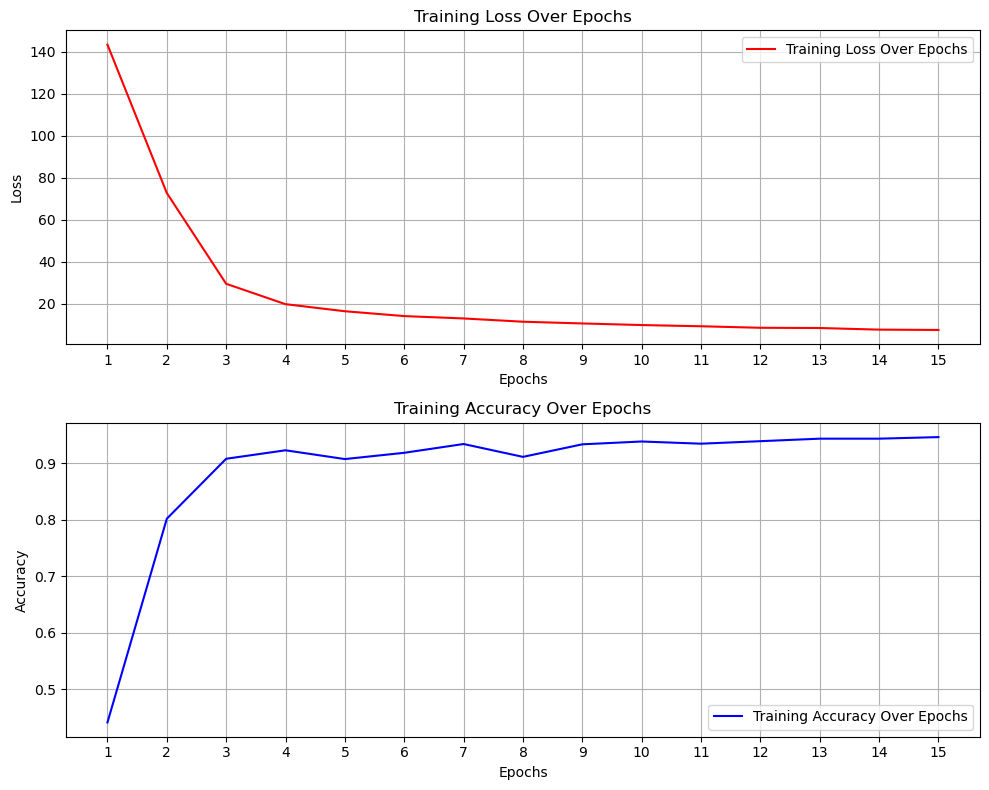

In [38]:
# plot training results
plot_training_results(accuracies, losses)

In [39]:
# show some predictions
test_data_subset = test_data[:10]
for i in range(10):
    pred = model(test_data_subset[i][0])
    print(f"Data point {i+1}:")
    print(f"Prediction: {np.argmax(pred)}")
    print(f"Actual target: {np.argmax(test_data_subset[i][1])}")
    print()

Data point 1:
Prediction: 8
Actual target: 8

Data point 2:
Prediction: 8
Actual target: 8

Data point 3:
Prediction: 6
Actual target: 6

Data point 4:
Prediction: 1
Actual target: 1

Data point 5:
Prediction: 2
Actual target: 2

Data point 6:
Prediction: 1
Actual target: 1

Data point 7:
Prediction: 7
Actual target: 7

Data point 8:
Prediction: 1
Actual target: 1

Data point 9:
Prediction: 2
Actual target: 2

Data point 10:
Prediction: 1
Actual target: 1

